https://www.kaggle.com/pranavraikokte/covid19-image-dataset

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import importlib
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
# Step 1: Loading in Dataset
ds_directory = '/home/zrarnz/9-Projects/ECET380/IntelImageSceneClassification/train'
os.listdir(ds_directory)
ts_directory = '/home/zrarnz/9-Projects/ECET380/IntelImageSceneClassification/test'

In [3]:
# Load in ordered dataset
BATCH_SIZE = 16
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
train_set = image_dataset_from_directory(ds_directory,
                        shuffle=True,
                        validation_split=0.2,
                        subset="training",
                        seed=123,
                        batch_size=BATCH_SIZE,
                        image_size=IMG_SIZE,
                        labels="inferred",
                        label_mode='int')


Found 14034 files belonging to 6 classes.
Using 11228 files for training.


In [4]:
val_set = image_dataset_from_directory(ds_directory,
                        shuffle=True,
                        validation_split=0.2,
                        subset="validation",
                        seed=123,
                        batch_size=BATCH_SIZE,
                        image_size=IMG_SIZE,
                        labels="inferred",
                        label_mode='int')

Found 14034 files belonging to 6 classes.
Using 2806 files for validation.


In [5]:
test_set = image_dataset_from_directory(ts_directory,
                        shuffle=True,
                        batch_size=BATCH_SIZE,
                        image_size=IMG_SIZE,
                        labels="inferred",
                        label_mode='int')

Found 3000 files belonging to 6 classes.


In [6]:
train_set.class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [7]:
# dataset_size = 181
# batch_size = BATCH_SIZE

def preprocess(image, label):
    # resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.efficientnet.preprocess_input(image)
    return final_image, label

# train_set = train_set.shuffle(1000)
train_set = train_set.map(preprocess).prefetch(1)
val_set = val_set.map(preprocess).prefetch(1)
test_set = test_set.map(preprocess).prefetch(1)

In [8]:
print('Number of fullset batches: %d' % tf.data.experimental.cardinality(train_set))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_set))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_set))

Number of fullset batches: 702
Number of validation batches: 176
Number of test batches: 188


In [9]:
base_model = tf.keras.applications.EfficientNetB4(input_shape=IMG_SHAPE,
                                                  input_tensor=None,
                                               include_top=False,
                                               pooling=None,
                                                classes=1000,
                                               weights='imagenet')

In [10]:
for layer in base_model.layers:
    layer.trainable = False

avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(
    units = 6, 
    activation = "softmax")(avg)

model = keras.models.Model(
    inputs = base_model.input,
    outputs = output)

model.compile(
    optimizer = keras.optimizers.SGD(
        learning_rate = 0.02,
        ),
    loss = "sparse_categorical_crossentropy", 
    metrics = ['accuracy'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [11]:
# tuner = kt.RandomSearch(
#             model_builder,
#             objective='val_accuracy',
#             max_trials=27,
#             seed=0,
#             overwrite=True,
#             executions_per_trial=2)

In [12]:
pre_early = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)
pre_chckp = keras.callbacks.ModelCheckpoint("effdetb4_intelscene_pretune.h5", save_best_only=True)

In [13]:
len(model.trainable_variables)


2

In [14]:
model.fit(train_set,
            validation_data=val_set,
            epochs=32,
            callbacks=[pre_early, pre_chckp],
#             steps_per_epoch=int(0.75 * DATASET_SIZE / BATCH_SIZE),
#             validation_steps=int(0.15 * DATASET_SIZE / BATCH_SIZE),
            )

Epoch 1/32
702/702 [==============================] - 134s 177ms/step - loss: 0.5864 - accuracy: 0.8227 - val_loss: 0.2709 - val_accuracy: 0.9084
Epoch 2/32
702/702 [==============================] - 146s 207ms/step - loss: 0.2675 - accuracy: 0.9058 - val_loss: 0.2466 - val_accuracy: 0.9127
Epoch 3/32
702/702 [==============================] - 154s 220ms/step - loss: 0.2434 - accuracy: 0.9178 - val_loss: 0.2333 - val_accuracy: 0.9155
Epoch 4/32
702/702 [==============================] - 159s 226ms/step - loss: 0.2297 - accuracy: 0.9213 - val_loss: 0.2262 - val_accuracy: 0.9198
Epoch 5/32
702/702 [==============================] - 157s 223ms/step - loss: 0.2257 - accuracy: 0.9219 - val_loss: 0.2215 - val_accuracy: 0.9212
Epoch 6/32
702/702 [==============================] - 159s 227ms/step - loss: 0.2168 - accuracy: 0.9261 - val_loss: 0.2194 - val_accuracy: 0.9223
Epoch 7/32
702/702 [==============================] - 156s 222ms/step - loss: 0.2053 - accuracy: 0.9258 - val_loss: 0.2161 -

In [15]:
model.evaluate(test_set)

188/188 [==============================] - 37s 195ms/step - loss: 0.2065 - accuracy: 0.9233


[0.20648394525051117, 0.9233333468437195]

In [16]:

train_set = train_set.shuffle(1000)


In [17]:
print('Number of fullset batches: %d' % tf.data.experimental.cardinality(train_set))


print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_set))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_set))

Number of fullset batches: 702
Number of validation batches: 176
Number of test batches: 188


In [18]:
model2 = keras.models.load_model("effdetb4_intelscene_pretune.h5")

In [19]:
for layer in model2.layers:
        layer.trainable=True

In [20]:
optimizer2 = keras.optimizers.SGD(learning_rate=0.002)

In [21]:
post_early = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True)
post_chckp = keras.callbacks.ModelCheckpoint("effdetb4_intelscene_posttune.h5", save_best_only=True)

In [22]:
model2.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer2,
    metrics="accuracy"
)

In [23]:
history = model2.fit(
    train_set,
    validation_data=val_set,
    epochs=64,
    callbacks=[post_early, post_chckp]
)

Epoch 1/64
702/702 [==============================] - 656s 899ms/step - loss: 0.7610 - accuracy: 0.7340 - val_loss: 0.4114 - val_accuracy: 0.8785
Epoch 2/64
702/702 [==============================] - 644s 903ms/step - loss: 0.4384 - accuracy: 0.8567 - val_loss: 0.3301 - val_accuracy: 0.9034
Epoch 3/64
702/702 [==============================] - 662s 929ms/step - loss: 0.3469 - accuracy: 0.8863 - val_loss: 0.2946 - val_accuracy: 0.9120
Epoch 4/64
702/702 [==============================] - 672s 940ms/step - loss: 0.3096 - accuracy: 0.8940 - val_loss: 0.2722 - val_accuracy: 0.9173
Epoch 5/64
702/702 [==============================] - 650s 905ms/step - loss: 0.2831 - accuracy: 0.9056 - val_loss: 0.2561 - val_accuracy: 0.9187
Epoch 6/64
702/702 [==============================] - 650s 909ms/step - loss: 0.2530 - accuracy: 0.9139 - val_loss: 0.2492 - val_accuracy: 0.9212
Epoch 7/64
702/702 [==============================] - 651s 906ms/step - loss: 0.2390 - accuracy: 0.9212 - val_loss: 0.2395 -

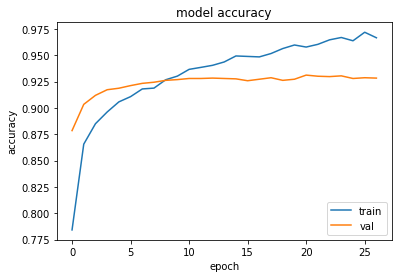

In [24]:
fig_acc = plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')

In [25]:
model2.evaluate(test_set)

188/188 [==============================] - 40s 209ms/step - loss: 0.2120 - accuracy: 0.9300


[0.21200403571128845, 0.9300000071525574]

In [26]:
evalPipe=test_set
for feats,lab in evalPipe.unbatch().batch(6000).take(1):
	probPreds=model2.predict(feats)

top1err=tf.reduce_mean(keras.metrics.sparse_top_k_categorical_accuracy(lab,probPreds,k=1))
top5err=tf.reduce_mean(keras.metrics.sparse_top_k_categorical_accuracy(lab,probPreds,k=5))
top10err=tf.reduce_mean(keras.metrics.sparse_top_k_categorical_accuracy(lab,probPreds,k=10))
print(top10err, top5err, top1err)

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.9996667, shape=(), dtype=float32) tf.Tensor(0.93, shape=(), dtype=float32)
